# Modelos Predictivos Andes - Airbnb Tokyo

**Ana Sofia Arizmendi - Universidad de los Andes**

**Etapa 4b: Modelos de Redes Neuronales para Regresion y Clasificacion**

1. **Regresion**: Prediccion del precio por noche usando redes neuronales
2. **Clasificacion**: Clasificar listings como "recomendados" o "no recomendados"

Incluye ingenieria de caracteristicas, busqueda amplia de hiperparametros, y seguimiento de experimentos con MLflow.

## 1. Importacion de Librerias y Configuracion

In [1]:
# ==========================================
# Importación de librerías principales
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import re
import json

# ==========================================
# Preprocesamiento y Modelado - sklearn
# ==========================================
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos clásicos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor

# Métricas
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# ==========================================
# Deep Learning - TensorFlow / Keras
# ==========================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2, l1_l2

# ==========================================
# MLflow para tracking de experimentos
# ==========================================
import mlflow
import mlflow.keras
import mlflow.sklearn

# ==========================================
# Configuraciones generales
# ==========================================
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("MLflow version:", mlflow.__version__)


2025-11-26 01:42:51.683343: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/anasofiaarizmendi/Desktop/Analitica/Proyecto_2/airbnb-env/lib/python3.11/site-packages/mlflow/utils/requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


TensorFlow version: 2.15.0
MLflow version: 2.14.3


## 2. Carga y Revision del Dataset Original

In [2]:
# Cargar el dataset original para aplicar correcciones
data = pd.read_csv("listings.csv")

print("=" * 60)
print("DATASET ORIGINAL")
print("=" * 60)
print(f"Dimensiones: {data.shape[0]} filas x {data.shape[1]} columnas")
print(f"\nPrimeras columnas: {list(data.columns[:20])}")

DATASET ORIGINAL
Dimensiones: 25297 filas x 79 columnas

Primeras columnas: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url']


## 3. Limpieza y Preparacion de Datos (Corregida)

Se aplican correcciones a los problemas identificados en el notebook Datos.ipynb:
- Eliminacion de columnas con data leakage (estimated_revenue_l365d)
- Eliminacion de registros sin precio (NO imputar el target)
- Tratamiento adecuado de outliers
- Encoding apropiado de variables categoricas

In [3]:
# -----------------------------------------------------------------------------
# 3.1 LIMPIEZA INICIAL
# -----------------------------------------------------------------------------

# Eliminar columnas con 100% valores nulos
cols_all_null = ['neighbourhood_group_cleansed', 'calendar_updated']
cols_all_null = [c for c in cols_all_null if c in data.columns]
data.drop(columns=cols_all_null, inplace=True, errors='ignore')

# Convertir precio a numerico
data['price'] = data['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
data['price'] = pd.to_numeric(data['price'], errors='coerce')

# Eliminar registros sin precio (NO imputar el target)
registros_iniciales = len(data)
data = data[data['price'].notna()].copy()
print(f"Registros eliminados por precio nulo: {registros_iniciales - len(data)}")

# Eliminar precios extremos (outliers) - el precio en Tokyo esta en JPY
precio_q1 = data['price'].quantile(0.01)
precio_q99 = data['price'].quantile(0.99)
print(f"Rango de precios (percentiles 1-99): {precio_q1:.0f} - {precio_q99:.0f} JPY")

# Filtrar outliers extremos
data = data[(data['price'] >= 1000) & (data['price'] <= 200000)].copy()
print(f"Registros despues de filtrar outliers de precio: {len(data)}")

Registros eliminados por precio nulo: 2037
Rango de precios (percentiles 1-99): 3936 - 100000 JPY
Registros despues de filtrar outliers de precio: 23138


In [5]:
# -----------------------------------------------------------------------------
# 3.2 CONVERSION DE TIPOS Y LIMPIEZA DE COLUMNAS
# -----------------------------------------------------------------------------

# Convertir tasas de porcentaje a proporciones
for col in ['host_response_rate', 'host_acceptance_rate']:
    if col in data.columns:
        data[col] = data[col].astype(str).str.replace('%', '', regex=False)
        data[col] = pd.to_numeric(data[col], errors='coerce') / 100

# Convertir fechas
date_columns = ['last_scraped', 'host_since', 'first_review', 'last_review', 'calendar_last_scraped']
for col in date_columns:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

# Convertir booleanos t/f a 1/0
bool_columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
                'has_availability', 'instant_bookable']
for col in bool_columns:
    if col in data.columns:
        data[col] = data[col].map({'t': 1, 'f': 0})
        data[col] = pd.to_numeric(data[col], errors='coerce')


In [6]:
# -----------------------------------------------------------------------------
# 3.3 SELECCION DE FEATURES RELEVANTES PARA MODELADO
# -----------------------------------------------------------------------------

# Definir columnas a ELIMINAR (no utiles para prediccion o causan leakage)
cols_to_drop = [
    # Identificadores
    'id', 'scrape_id', 'host_id', 'listing_url', 'host_url',

    # URLs e imagenes
    'picture_url', 'host_thumbnail_url', 'host_picture_url',

    # Texto libre de alta cardinalidad
    'name', 'description', 'neighborhood_overview', 'host_name', 'host_about',
    'host_location', 'host_neighbourhood', 'neighbourhood',

    # Texto que requiere NLP
    'amenities', 'host_verifications', 'bathrooms_text', 'license',

    # Fechas de scraping (no predictivas)
    'last_scraped', 'calendar_last_scraped', 'source',

    # DATA LEAKAGE - variables derivadas del precio o comportamiento futuro
    'estimated_revenue_l365d',  # Calculado a partir del precio

    # Redundantes
    'host_total_listings_count',  # Muy similar a host_listings_count
    'minimum_minimum_nights', 'maximum_minimum_nights',
    'minimum_maximum_nights', 'maximum_maximum_nights',

    # Muy alta correlacion con otras (evitar multicolinealidad)
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms',
]

# Eliminar columnas que existan
cols_to_drop_exist = [c for c in cols_to_drop if c in data.columns]
data.drop(columns=cols_to_drop_exist, inplace=True)
print(f"Columnas eliminadas: {len(cols_to_drop_exist)}")
print(f"Columnas restantes: {len(data.columns)}")

Columnas eliminadas: 32
Columnas restantes: 45


In [7]:
# -----------------------------------------------------------------------------
# 3.4 INGENIERIA DE CARACTERISTICAS
# -----------------------------------------------------------------------------

# Calcular antiguedad del host (en dias desde la fecha de referencia)
ref_date = pd.Timestamp('2025-07-01')  # Fecha aproximada del scraping
if 'host_since' in data.columns:
    data['host_tenure_days'] = (ref_date - data['host_since']).dt.days
    data['host_tenure_days'] = data['host_tenure_days'].clip(lower=0)
    data.drop(columns=['host_since'], inplace=True)

# Calcular tiempo desde primer y ultimo review
if 'first_review' in data.columns:
    data['days_since_first_review'] = (ref_date - data['first_review']).dt.days
    data['days_since_first_review'] = data['days_since_first_review'].clip(lower=0)
    data.drop(columns=['first_review'], inplace=True)

if 'last_review' in data.columns:
    data['days_since_last_review'] = (ref_date - data['last_review']).dt.days
    data['days_since_last_review'] = data['days_since_last_review'].clip(lower=0)
    data.drop(columns=['last_review'], inplace=True)

# Indicador de si tiene reviews
data['has_reviews'] = (data['number_of_reviews'] > 0).astype(int)

# Promedio de scores de reviews (para listings con reviews)
review_score_cols = ['review_scores_rating', 'review_scores_accuracy',
                     'review_scores_cleanliness', 'review_scores_checkin',
                     'review_scores_communication', 'review_scores_location',
                     'review_scores_value']
review_score_cols = [c for c in review_score_cols if c in data.columns]

if review_score_cols:
    data['avg_review_score'] = data[review_score_cols].mean(axis=1)

# Ocupacion estimada como proxy de demanda
if 'estimated_occupancy_l365d' in data.columns:
    data['occupancy_rate'] = data['estimated_occupancy_l365d'] / 365

# Ratio de disponibilidad a corto vs largo plazo
if 'availability_30' in data.columns and 'availability_365' in data.columns:
    data['availability_ratio_30_365'] = np.where(
        data['availability_365'] > 0,
        data['availability_30'] / data['availability_365'],
        0
    )

print("Features de ingenieria creadas")
print(f"Total de columnas: {len(data.columns)}")

Features de ingenieria creadas
Total de columnas: 49


In [8]:
# -----------------------------------------------------------------------------
# 3.5 IMPUTACION DE VALORES FALTANTES (SIN IMPUTAR EL TARGET)
# -----------------------------------------------------------------------------

# Separar columnas numericas y categoricas
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

# Remover price de la lista de numericas (es el target)
if 'price' in numeric_cols:
    numeric_cols.remove('price')

print(f"Columnas numericas: {len(numeric_cols)}")
print(f"Columnas categoricas: {len(categorical_cols)}")

# Imputar numericas con mediana
for col in numeric_cols:
    if data[col].isnull().any():
        median_val = data[col].median()
        data[col] = data[col].fillna(median_val)

# Imputar categoricas con moda o 'Unknown'
for col in categorical_cols:
    if data[col].isnull().any():
        mode_val = data[col].mode()
        if len(mode_val) > 0:
            data[col] = data[col].fillna(mode_val[0])
        else:
            data[col] = data[col].fillna('Unknown')

# Verificar que no hay valores nulos
print(f"\nValores nulos restantes: {data.isnull().sum().sum()}")

Columnas numericas: 44
Columnas categoricas: 4

Valores nulos restantes: 115690


In [10]:
# -----------------------------------------------------------------------------
# 3.6 ENCODING DE VARIABLES CATEGORICAS
# -----------------------------------------------------------------------------

# Simplificar property_type (agrupar categorias raras)
if 'property_type' in data.columns:
    property_counts = data['property_type'].value_counts()
    rare_properties = property_counts[property_counts < 100].index
    data['property_type'] = data['property_type'].replace(rare_properties, 'Other')
    print(f"Categorias de property_type: {data['property_type'].nunique()}")

# Simplificar neighbourhood_cleansed (agrupar barrios con pocos listings)
if 'neighbourhood_cleansed' in data.columns:
    neigh_counts = data['neighbourhood_cleansed'].value_counts()
    rare_neigh = neigh_counts[neigh_counts < 50].index
    data['neighbourhood_cleansed'] = data['neighbourhood_cleansed'].replace(rare_neigh, 'Other')
    print(f"Categorias de neighbourhood: {data['neighbourhood_cleansed'].nunique()}")

# Mostrar categoricas finales
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nVariables categoricas finales: {categorical_cols}")
for col in categorical_cols:
    print(f"  {col}: {data[col].nunique()} categorias")

Categorias de property_type: 12
Categorias de neighbourhood: 25

Variables categoricas finales: ['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type']
  host_response_time: 4 categorias
  neighbourhood_cleansed: 25 categorias
  property_type: 12 categorias
  room_type: 4 categorias


In [11]:
# -----------------------------------------------------------------------------
# 3.7 DATASET FINAL PARA MODELADO
# -----------------------------------------------------------------------------

# Verificar el dataset final
print("=" * 60)
print("DATASET FINAL PARA MODELADO")
print("=" * 60)
print(f"Dimensiones: {data.shape[0]} filas x {data.shape[1]} columnas")
print(f"\nTarget (price):")
print(data['price'].describe())

# Guardar dataset limpio
data.to_csv("listings_clean.csv", index=False)
print("\nDataset limpio guardado como 'listings_clean.csv'")

DATASET FINAL PARA MODELADO
Dimensiones: 23138 filas x 49 columnas

Target (price):
count     23138.000000
mean      18257.153643
std       15082.022428
min        1700.000000
25%        9434.250000
50%       13972.000000
75%       21715.000000
max      200000.000000
Name: price, dtype: float64

Dataset limpio guardado como 'listings_clean.csv'


## 4. Preparacion de Datos para Modelado

In [12]:
# -----------------------------------------------------------------------------
# 4.1 DEFINIR TARGET Y FEATURES
# -----------------------------------------------------------------------------

# Target para regresion
y_reg = data['price'].values

# Log-transform del precio para mejor distribucion
y_reg_log = np.log1p(y_reg)

# Features (excluir target)
feature_cols = [c for c in data.columns if c != 'price']
X = data[feature_cols].copy()

# Separar numericas y categoricas
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Features numericas: {len(numeric_features)}")
print(f"Features categoricas: {len(categorical_features)}")
print(f"Total features: {len(feature_cols)}")

Features numericas: 44
Features categoricas: 4
Total features: 48


In [13]:
# -----------------------------------------------------------------------------
# 4.2 PREPROCESAMIENTO CON SKLEARN PIPELINE
# -----------------------------------------------------------------------------

# Preprocessor para numericas: imputar + escalar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessor para categoricas: imputar + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinar en ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [14]:
# -----------------------------------------------------------------------------
# 4.3 TRAIN/TEST SPLIT
# -----------------------------------------------------------------------------

# Split para regresion (usando log del precio)
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg_log, test_size=0.2, random_state=42
)

# Guardar los valores originales (no log) para evaluacion
y_train_reg_orig = np.expm1(y_train_reg)
y_test_reg_orig = np.expm1(y_test_reg)

print(f"Train set: {X_train.shape[0]} registros")
print(f"Test set: {X_test.shape[0]} registros")

# Fit preprocessor en train y transformar
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nDimensiones despues de preprocessing:")
print(f"X_train_processed: {X_train_processed.shape}")
print(f"X_test_processed: {X_test_processed.shape}")

# Obtener nombres de features despues del encoding
feature_names_out = []
feature_names_out.extend(numeric_features)
if categorical_features:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(categorical_features)
    feature_names_out.extend(cat_feature_names)

print(f"Total features despues de encoding: {len(feature_names_out)}")

Train set: 18510 registros
Test set: 4628 registros

Dimensiones despues de preprocessing:
X_train_processed: (18510, 84)
X_test_processed: (4628, 84)
Total features despues de encoding: 89


## 5. MODELOS DE REGRESION

### Objetivo
Predecir el precio por noche de un listing de Airbnb en Tokyo.

### Modelos a implementar
- Baseline: Linear Regression, Ridge, Random Forest
- Neural Network con busqueda de hiperparametros

In [15]:
# -----------------------------------------------------------------------------
# 5.1 CONFIGURACION DE MLFLOW
# -----------------------------------------------------------------------------

# Crear directorio para MLflow
mlflow_dir = "mlruns"
os.makedirs(mlflow_dir, exist_ok=True)

# Configurar MLflow
mlflow.set_tracking_uri(f"file:{mlflow_dir}")
experiment_name = "Airbnb_Tokyo_Price_Prediction"

# Crear u obtener el experimento
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    experiment_id = experiment.experiment_id

mlflow.set_experiment(experiment_name)
print(f"MLflow experiment: {experiment_name}")
print(f"Experiment ID: {experiment_id}")

MLflow experiment: Airbnb_Tokyo_Price_Prediction
Experiment ID: 997002668754835954


In [16]:
# -----------------------------------------------------------------------------
# 5.2 FUNCION DE EVALUACION PARA REGRESION
# -----------------------------------------------------------------------------

def evaluate_regression(y_true, y_pred, y_true_orig=None, y_pred_orig=None, prefix=""):
    """
    Evalua modelo de regresion con multiples metricas.
    Si se pasan valores originales (no log), calcula metricas en escala original.
    """
    metrics = {}

    # Metricas en escala log
    metrics[f'{prefix}rmse_log'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics[f'{prefix}mae_log'] = mean_absolute_error(y_true, y_pred)
    metrics[f'{prefix}r2_log'] = r2_score(y_true, y_pred)

    # Metricas en escala original (JPY)
    if y_true_orig is not None and y_pred_orig is not None:
        metrics[f'{prefix}rmse'] = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
        metrics[f'{prefix}mae'] = mean_absolute_error(y_true_orig, y_pred_orig)
        metrics[f'{prefix}r2'] = r2_score(y_true_orig, y_pred_orig)
        metrics[f'{prefix}mape'] = np.mean(np.abs((y_true_orig - y_pred_orig) / y_true_orig)) * 100

    return metrics

def print_regression_metrics(metrics, model_name="Model"):
    """Imprime metricas de regresion de forma legible."""
    print(f"\n{'='*50}")
    print(f"Resultados: {model_name}")
    print(f"{'='*50}")
    for key, value in metrics.items():
        if 'mape' in key.lower():
            print(f"{key}: {value:.2f}%")
        elif 'r2' in key.lower():
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value:.2f}")

In [17]:
# -----------------------------------------------------------------------------
# 5.3 MODELOS BASELINE DE REGRESION
# -----------------------------------------------------------------------------

print("=" * 60)
print("MODELOS BASELINE DE REGRESION")
print("=" * 60)

baseline_results = {}

# Linear Regression
with mlflow.start_run(run_name="LinearRegression_Baseline"):
    lr_model = LinearRegression()
    lr_model.fit(X_train_processed, y_train_reg)

    y_pred_train_log = lr_model.predict(X_train_processed)
    y_pred_test_log = lr_model.predict(X_test_processed)

    # Convertir a escala original
    y_pred_train_orig = np.expm1(y_pred_train_log)
    y_pred_test_orig = np.expm1(y_pred_test_log)

    # Evaluar
    train_metrics = evaluate_regression(y_train_reg, y_pred_train_log,
                                        y_train_reg_orig, y_pred_train_orig, "train_")
    test_metrics = evaluate_regression(y_test_reg, y_pred_test_log,
                                       y_test_reg_orig, y_pred_test_orig, "test_")

    # Log en MLflow
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_metrics(train_metrics)
    mlflow.log_metrics(test_metrics)
    mlflow.sklearn.log_model(lr_model, "model")

    baseline_results['LinearRegression'] = test_metrics
    print_regression_metrics(test_metrics, "Linear Regression")

MODELOS BASELINE DE REGRESION

Resultados: Linear Regression
test_rmse_log: 0.39
test_mae_log: 0.30
test_r2_log: 0.6059
test_rmse: 11790.77
test_mae: 5869.24
test_r2: 0.4420
test_mape: 29.99%


In [18]:
# Ridge Regression
with mlflow.start_run(run_name="Ridge_Baseline"):
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train_processed, y_train_reg)

    y_pred_train_log = ridge_model.predict(X_train_processed)
    y_pred_test_log = ridge_model.predict(X_test_processed)

    y_pred_train_orig = np.expm1(y_pred_train_log)
    y_pred_test_orig = np.expm1(y_pred_test_log)

    train_metrics = evaluate_regression(y_train_reg, y_pred_train_log,
                                        y_train_reg_orig, y_pred_train_orig, "train_")
    test_metrics = evaluate_regression(y_test_reg, y_pred_test_log,
                                       y_test_reg_orig, y_pred_test_orig, "test_")

    mlflow.log_param("model_type", "Ridge")
    mlflow.log_param("alpha", 1.0)
    mlflow.log_metrics(train_metrics)
    mlflow.log_metrics(test_metrics)
    mlflow.sklearn.log_model(ridge_model, "model")

    baseline_results['Ridge'] = test_metrics
    print_regression_metrics(test_metrics, "Ridge Regression")


Resultados: Ridge Regression
test_rmse_log: 0.39
test_mae_log: 0.30
test_r2_log: 0.6060
test_rmse: 11792.27
test_mae: 5869.08
test_r2: 0.4418
test_mape: 29.98%


In [ ]:
# Random Forest
with mlflow.start_run(run_name="RandomForest_Baseline"):
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=15,
                                     min_samples_split=5, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_processed, y_train_reg)

    y_pred_train_log = rf_model.predict(X_train_processed)
    y_pred_test_log = rf_model.predict(X_test_processed)

    y_pred_train_orig = np.expm1(y_pred_train_log)
    y_pred_test_orig = np.expm1(y_pred_test_log)

    train_metrics = evaluate_regression(y_train_reg, y_pred_train_log,
                                        y_train_reg_orig, y_pred_train_orig, "train_")
    test_metrics = evaluate_regression(y_test_reg, y_pred_test_log,
                                       y_test_reg_orig, y_pred_test_orig, "test_")

    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 15)
    mlflow.log_metrics(train_metrics)
    mlflow.log_metrics(test_metrics)
    mlflow.sklearn.log_model(rf_model, "model")

    baseline_results['RandomForest'] = test_metrics
    print_regression_metrics(test_metrics, "Random Forest")

    # Feature importance
n_features = len(rf_model.feature_importances_)

# Si feature_names_out existe pero tiene más o menos elementos, ajustar:
try:
    feature_names_adjusted = np.array(feature_names_out[:n_features])
except NameError:
    # Si no existe feature_names_out, usamos nombres genéricos
    feature_names_adjusted = np.array([f"feature_{i}" for i in range(n_features)])

feature_importance = pd.DataFrame({
    "feature": feature_names_adjusted,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop 15 Features más importantes (Random Forest):")
print(feature_importance.head(15).to_string(index=False))



Resultados: Random Forest
test_rmse_log: 0.33
test_mae_log: 0.23
test_r2_log: 0.7287
test_rmse: 10691.44
test_mae: 4834.84
test_r2: 0.5412
test_mape: 23.28%

Top 15 Features más importantes (Random Forest):
                             feature  importance
              host_identity_verified    0.446093
                 host_listings_count    0.105353
                host_has_profile_pic    0.067883
                           longitude    0.049141
property_type_Room in boutique hotel    0.018032
                number_of_reviews_ly    0.017584
                            latitude    0.017140
                                beds    0.016637
              review_scores_location    0.015832
                    has_availability    0.015263
                    instant_bookable    0.012923
               review_scores_checkin    0.012103
                   host_is_superhost    0.010840
              review_scores_accuracy    0.010730
                    availability_365    0.010361


### 5.4 Red Neuronal para Regresion - Busqueda de Hiperparametros

In [21]:
# -----------------------------------------------------------------------------
# 5.4 RED NEURONAL PARA REGRESION - BUSQUEDA DE HIPERPARAMETROS
# -----------------------------------------------------------------------------

print("\n" + "=" * 60)
print("REDES NEURONALES PARA REGRESION - BUSQUEDA DE HIPERPARAMETROS")
print("=" * 60)

def build_regression_nn(input_dim, hidden_layers, neurons_per_layer,
                        activation='relu', dropout_rate=0.2,
                        learning_rate=0.001, l2_reg=0.01):
    """
    Construye una red neuronal para regresion.

    Args:
        input_dim: Dimension de entrada
        hidden_layers: Numero de capas ocultas
        neurons_per_layer: Lista con neuronas por capa o int para todas iguales
        activation: Funcion de activacion
        dropout_rate: Tasa de dropout
        learning_rate: Tasa de aprendizaje
        l2_reg: Regularizacion L2
    """
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    # Convertir neurons_per_layer a lista si es int
    if isinstance(neurons_per_layer, int):
        neurons_per_layer = [neurons_per_layer] * hidden_layers

    for i in range(hidden_layers):
        neurons = neurons_per_layer[i] if i < len(neurons_per_layer) else neurons_per_layer[-1]
        model.add(Dense(neurons, activation=activation,
                       kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Capa de salida (regresion = 1 neurona, activacion lineal)
    model.add(Dense(1, activation='linear'))

    # Compilar
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


REDES NEURONALES PARA REGRESION - BUSQUEDA DE HIPERPARAMETROS


In [22]:
# Definir espacio de hiperparametros para busqueda
hyperparameter_space = {
    'hidden_layers': [2, 3, 4],
    'neurons': [[128, 64], [256, 128, 64], [128, 128, 64, 32], [256, 128]],
    'activation': ['relu', 'leaky_relu', 'elu'],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [32, 64, 128],
    'l2_reg': [0.001, 0.01, 0.0001]
}

# Configuraciones a probar (muestreo representativo del espacio)
configs_to_try = [
    {'hidden_layers': 2, 'neurons': [128, 64], 'activation': 'relu',
     'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01},

    {'hidden_layers': 3, 'neurons': [256, 128, 64], 'activation': 'relu',
     'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01},

    {'hidden_layers': 3, 'neurons': [256, 128, 64], 'activation': 'relu',
     'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32, 'l2_reg': 0.001},

    {'hidden_layers': 4, 'neurons': [256, 128, 64, 32], 'activation': 'elu',
     'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01},

    {'hidden_layers': 2, 'neurons': [256, 128], 'activation': 'relu',
     'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 128, 'l2_reg': 0.001},

    {'hidden_layers': 3, 'neurons': [128, 128, 64], 'activation': 'leaky_relu',
     'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.0001},

    {'hidden_layers': 4, 'neurons': [512, 256, 128, 64], 'activation': 'relu',
     'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 32, 'l2_reg': 0.01},

    {'hidden_layers': 2, 'neurons': [64, 32], 'activation': 'relu',
     'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01},
]

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True, verbose=0
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0
)

In [23]:
# Ejecutar busqueda de hiperparametros
nn_results = []
best_nn_model = None
best_nn_score = float('inf')

input_dim = X_train_processed.shape[1]

for i, config in enumerate(configs_to_try):
    print(f"\nConfiguracion {i+1}/{len(configs_to_try)}: {config}")

    with mlflow.start_run(run_name=f"NN_Regression_Config_{i+1}"):
        # Log hiperparametros
        for key, value in config.items():
            mlflow.log_param(key, str(value))
        mlflow.log_param("model_type", "NeuralNetwork_Regression")
        mlflow.log_param("input_dim", input_dim)

        # Construir modelo
        model = build_regression_nn(
            input_dim=input_dim,
            hidden_layers=config['hidden_layers'],
            neurons_per_layer=config['neurons'],
            activation=config['activation'],
            dropout_rate=config['dropout_rate'],
            learning_rate=config['learning_rate'],
            l2_reg=config['l2_reg']
        )

        # Entrenar
        history = model.fit(
            X_train_processed, y_train_reg,
            validation_split=0.15,
            epochs=150,
            batch_size=config['batch_size'],
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )

        # Predicciones
        y_pred_train_log = model.predict(X_train_processed, verbose=0).flatten()
        y_pred_test_log = model.predict(X_test_processed, verbose=0).flatten()

        y_pred_train_orig = np.expm1(y_pred_train_log)
        y_pred_test_orig = np.expm1(y_pred_test_log)

        # Evaluar
        train_metrics = evaluate_regression(y_train_reg, y_pred_train_log,
                                           y_train_reg_orig, y_pred_train_orig, "train_")
        test_metrics = evaluate_regression(y_test_reg, y_pred_test_log,
                                          y_test_reg_orig, y_pred_test_orig, "test_")

        # Log metricas
        mlflow.log_metrics(train_metrics)
        mlflow.log_metrics(test_metrics)
        mlflow.log_metric("epochs_trained", len(history.history['loss']))

        # Log modelo
        mlflow.keras.log_model(model, "model")

        # Guardar resultados
        result = {'config': config, 'test_rmse': test_metrics['test_rmse'],
                  'test_mae': test_metrics['test_mae'], 'test_r2': test_metrics['test_r2']}
        nn_results.append(result)

        print(f"  Test RMSE: {test_metrics['test_rmse']:.2f} JPY | "
              f"Test MAE: {test_metrics['test_mae']:.2f} JPY | "
              f"Test R2: {test_metrics['test_r2']:.4f}")

        # Guardar mejor modelo
        if test_metrics['test_rmse'] < best_nn_score:
            best_nn_score = test_metrics['test_rmse']
            best_nn_model = model
            best_nn_config = config


Configuracion 1/8: {'hidden_layers': 2, 'neurons': [128, 64], 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01}


2025/11/26 02:02:48 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpsb93m6_f/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpsb93m6_f/model/data/model/assets


  Test RMSE: 10357.07 JPY | Test MAE: 4831.79 JPY | Test R2: 0.5694

Configuracion 2/8: {'hidden_layers': 3, 'neurons': [256, 128, 64], 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01}


2025/11/26 02:06:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpw4t7_pah/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpw4t7_pah/model/data/model/assets


  Test RMSE: 10432.94 JPY | Test MAE: 4834.90 JPY | Test R2: 0.5631

Configuracion 3/8: {'hidden_layers': 3, 'neurons': [256, 128, 64], 'activation': 'relu', 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32, 'l2_reg': 0.001}


2025/11/26 02:11:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpy61p7jsn/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpy61p7jsn/model/data/model/assets


  Test RMSE: 10387.62 JPY | Test MAE: 4818.30 JPY | Test R2: 0.5669

Configuracion 4/8: {'hidden_layers': 4, 'neurons': [256, 128, 64, 32], 'activation': 'elu', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01}


2025/11/26 02:15:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpgwbgnzx0/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpgwbgnzx0/model/data/model/assets


  Test RMSE: 11404.59 JPY | Test MAE: 5428.94 JPY | Test R2: 0.4779

Configuracion 5/8: {'hidden_layers': 2, 'neurons': [256, 128], 'activation': 'relu', 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 128, 'l2_reg': 0.001}


2025/11/26 02:18:01 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmp7xu714x1/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmp7xu714x1/model/data/model/assets


  Test RMSE: 86795.14 JPY | Test MAE: 5973.53 JPY | Test R2: -29.2396

Configuracion 6/8: {'hidden_layers': 3, 'neurons': [128, 128, 64], 'activation': 'leaky_relu', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.0001}


2025/11/26 02:20:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpqz028akg/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpqz028akg/model/data/model/assets


  Test RMSE: 10454.50 JPY | Test MAE: 4863.72 JPY | Test R2: 0.5613

Configuracion 7/8: {'hidden_layers': 4, 'neurons': [512, 256, 128, 64], 'activation': 'relu', 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 32, 'l2_reg': 0.01}


2025/11/26 02:30:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpv93m2254/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpv93m2254/model/data/model/assets


  Test RMSE: 10606.48 JPY | Test MAE: 4947.29 JPY | Test R2: 0.5484

Configuracion 8/8: {'hidden_layers': 2, 'neurons': [64, 32], 'activation': 'relu', 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01}


2025/11/26 02:32:03 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpyt4m182o/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpyt4m182o/model/data/model/assets


  Test RMSE: 10489.67 JPY | Test MAE: 4923.08 JPY | Test R2: 0.5583


In [24]:
# Resumen de resultados de la busqueda
print("\n" + "=" * 60)
print("RESUMEN DE BUSQUEDA DE HIPERPARAMETROS - REGRESION")
print("=" * 60)

nn_results_df = pd.DataFrame(nn_results)
nn_results_df = nn_results_df.sort_values('test_rmse')
print(nn_results_df.to_string(index=False))

print(f"\n>>> Mejor configuracion: {best_nn_config}")
print(f">>> Mejor RMSE: {best_nn_score:.2f} JPY")


RESUMEN DE BUSQUEDA DE HIPERPARAMETROS - REGRESION
                                                                                                                                                      config    test_rmse    test_mae    test_r2
             {'hidden_layers': 2, 'neurons': [128, 64], 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01} 10357.074889 4831.793419   0.569415
      {'hidden_layers': 3, 'neurons': [256, 128, 64], 'activation': 'relu', 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'batch_size': 32, 'l2_reg': 0.001} 10387.620431 4818.299959   0.566871
        {'hidden_layers': 3, 'neurons': [256, 128, 64], 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01} 10432.937500 4834.904431   0.563084
{'hidden_layers': 3, 'neurons': [128, 128, 64], 'activation': 'leaky_relu', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.0001} 10454.498959 4863.7


EVALUACION FINAL - MEJOR MODELO DE REGRESION (RED NEURONAL)

Resultados: Mejor Red Neuronal
final_rmse_log: 0.33
final_mae_log: 0.24
final_r2_log: 0.7292
final_rmse: 10357.07
final_mae: 4831.79
final_r2: 0.5694
final_mape: 23.35%


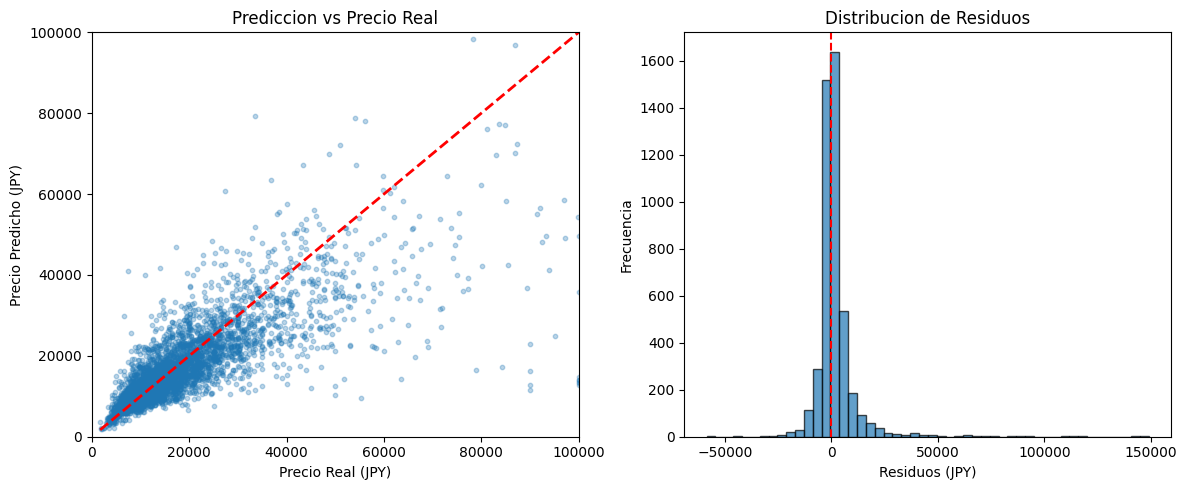


Modelo guardado como 'best_regression_model.keras'


In [25]:
# -----------------------------------------------------------------------------
# 5.5 EVALUACION FINAL DEL MEJOR MODELO DE REGRESION
# -----------------------------------------------------------------------------

print("\n" + "=" * 60)
print("EVALUACION FINAL - MEJOR MODELO DE REGRESION (RED NEURONAL)")
print("=" * 60)

# Predicciones finales
y_pred_final_log = best_nn_model.predict(X_test_processed, verbose=0).flatten()
y_pred_final = np.expm1(y_pred_final_log)

# Metricas finales
final_metrics = evaluate_regression(y_test_reg, y_pred_final_log,
                                    y_test_reg_orig, y_pred_final, "final_")
print_regression_metrics(final_metrics, "Mejor Red Neuronal")

# Grafico: Prediccion vs Real
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_reg_orig, y_pred_final, alpha=0.3, s=10)
plt.plot([y_test_reg_orig.min(), y_test_reg_orig.max()],
         [y_test_reg_orig.min(), y_test_reg_orig.max()], 'r--', lw=2)
plt.xlabel('Precio Real (JPY)')
plt.ylabel('Precio Predicho (JPY)')
plt.title('Prediccion vs Precio Real')
plt.xlim(0, 100000)
plt.ylim(0, 100000)

plt.subplot(1, 2, 2)
residuals = y_test_reg_orig - y_pred_final
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuos (JPY)')
plt.ylabel('Frecuencia')
plt.title('Distribucion de Residuos')
plt.axvline(x=0, color='r', linestyle='--')

plt.tight_layout()
plt.savefig('regression_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

# Guardar modelo final
best_nn_model.save('best_regression_model.keras')
print("\nModelo guardado como 'best_regression_model.keras'")

## 6. MODELO DE CLASIFICACION

### Definicion de la Etiqueta "Recomendado"

Criterios para clasificar un listing como "Recomendado":
1. Rating promedio >= 4.5
2. Numero de reviews >= 5 (evidencia suficiente)
3. Precio competitivo (no en el cuartil mas alto para su tipo de propiedad)
4. Host con buena reputacion (acceptance rate >= 0.8 o superhost)

Esta definicion combina calidad percibida, evidencia de demanda y valor.

In [26]:
# -----------------------------------------------------------------------------
# 6.1 CREAR VARIABLE TARGET PARA CLASIFICACION
# -----------------------------------------------------------------------------

print("=" * 60)
print("CREACION DE ETIQUETA 'RECOMENDADO'")
print("=" * 60)

# Usar el dataset limpio
data_class = data.copy()

# Criterio 1: Rating alto (>= 4.5)
if 'review_scores_rating' in data_class.columns:
    criterio_rating = data_class['review_scores_rating'] >= 4.5
else:
    criterio_rating = data_class['avg_review_score'] >= 4.5

# Criterio 2: Suficientes reviews (>= 5)
criterio_reviews = data_class['number_of_reviews'] >= 5

# Criterio 3: Precio competitivo
# Calcular percentil 75 del precio por room_type
if 'room_type' in data_class.columns:
    precio_p75 = data_class.groupby('room_type')['price'].transform(lambda x: x.quantile(0.75))
    criterio_precio = data_class['price'] <= precio_p75
else:
    criterio_precio = data_class['price'] <= data_class['price'].quantile(0.75)

# Criterio 4: Host confiable
criterio_host = (
    (data_class['host_acceptance_rate'] >= 0.8) |
    (data_class['host_is_superhost'] == 1)
)

# Combinar criterios: Recomendado si cumple al menos 3 de 4
criterios_cumplidos = (
    criterio_rating.astype(int) +
    criterio_reviews.astype(int) +
    criterio_precio.astype(int) +
    criterio_host.astype(int)
)

data_class['recommended'] = (criterios_cumplidos >= 3).astype(int)

# Estadisticas de la variable target
print(f"\nDistribucion de la etiqueta 'recommended':")
print(data_class['recommended'].value_counts())
print(f"\nPorcentaje de recomendados: {data_class['recommended'].mean()*100:.1f}%")

CREACION DE ETIQUETA 'RECOMENDADO'

Distribucion de la etiqueta 'recommended':
recommended
0    12521
1    10617
Name: count, dtype: int64

Porcentaje de recomendados: 45.9%


In [27]:
# -----------------------------------------------------------------------------
# 6.2 PREPARAR DATOS PARA CLASIFICACION
# -----------------------------------------------------------------------------

# Features para clasificacion (incluimos price porque esta disponible)
y_class = data_class['recommended'].values

# Remover la variable target del dataframe de features
X_class = data_class.drop(columns=['recommended'])

# Usar el mismo preprocessor
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Fit nuevo preprocessor
numeric_features_class = X_class.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_class = X_class.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor_class = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_class),
        ('cat', categorical_transformer, categorical_features_class)
    ],
    remainder='drop'
)

X_train_class_processed = preprocessor_class.fit_transform(X_train_class)
X_test_class_processed = preprocessor_class.transform(X_test_class)

print(f"Train set clasificacion: {X_train_class_processed.shape}")
print(f"Test set clasificacion: {X_test_class_processed.shape}")
print(f"Balance de clases en train: {np.bincount(y_train_class)}")

Train set clasificacion: (18510, 85)
Test set clasificacion: (4628, 85)
Balance de clases en train: [10017  8493]


In [28]:
# -----------------------------------------------------------------------------
# 6.3 FUNCION DE EVALUACION PARA CLASIFICACION
# -----------------------------------------------------------------------------

def evaluate_classification(y_true, y_pred, y_proba=None, prefix=""):
    """Evalua modelo de clasificacion con multiples metricas."""
    metrics = {}

    metrics[f'{prefix}accuracy'] = accuracy_score(y_true, y_pred)
    metrics[f'{prefix}precision'] = precision_score(y_true, y_pred)
    metrics[f'{prefix}recall'] = recall_score(y_true, y_pred)
    metrics[f'{prefix}f1'] = f1_score(y_true, y_pred)

    if y_proba is not None:
        metrics[f'{prefix}roc_auc'] = roc_auc_score(y_true, y_proba)

    return metrics

def print_classification_metrics(metrics, model_name="Model"):
    """Imprime metricas de clasificacion."""
    print(f"\n{'='*50}")
    print(f"Resultados: {model_name}")
    print(f"{'='*50}")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

In [29]:
# -----------------------------------------------------------------------------
# 6.4 MODELOS BASELINE DE CLASIFICACION
# -----------------------------------------------------------------------------

print("\n" + "=" * 60)
print("MODELOS BASELINE DE CLASIFICACION")
print("=" * 60)

# Nuevo experimento para clasificacion
mlflow.set_experiment("Airbnb_Tokyo_Classification")

baseline_class_results = {}

# Logistic Regression
with mlflow.start_run(run_name="LogisticRegression_Baseline"):
    lr_class = LogisticRegression(max_iter=1000, random_state=42)
    lr_class.fit(X_train_class_processed, y_train_class)

    y_pred_class = lr_class.predict(X_test_class_processed)
    y_proba_class = lr_class.predict_proba(X_test_class_processed)[:, 1]

    test_metrics = evaluate_classification(y_test_class, y_pred_class, y_proba_class, "test_")

    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_metrics(test_metrics)
    mlflow.sklearn.log_model(lr_class, "model")

    baseline_class_results['LogisticRegression'] = test_metrics
    print_classification_metrics(test_metrics, "Logistic Regression")

    print("\nMatriz de Confusion:")
    print(confusion_matrix(y_test_class, y_pred_class))

2025/11/26 02:43:17 INFO mlflow.tracking.fluent: Experiment with name 'Airbnb_Tokyo_Classification' does not exist. Creating a new experiment.



MODELOS BASELINE DE CLASIFICACION

Resultados: Logistic Regression
test_accuracy: 0.8466
test_precision: 0.8148
test_recall: 0.8616
test_f1: 0.8375
test_roc_auc: 0.9284

Matriz de Confusion:
[[2088  416]
 [ 294 1830]]


In [30]:
# Random Forest Classifier
with mlflow.start_run(run_name="RandomForest_Classifier_Baseline"):
    rf_class = RandomForestClassifier(n_estimators=100, max_depth=15,
                                      min_samples_split=5, random_state=42, n_jobs=-1)
    rf_class.fit(X_train_class_processed, y_train_class)

    y_pred_class = rf_class.predict(X_test_class_processed)
    y_proba_class = rf_class.predict_proba(X_test_class_processed)[:, 1]

    test_metrics = evaluate_classification(y_test_class, y_pred_class, y_proba_class, "test_")

    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 15)
    mlflow.log_metrics(test_metrics)
    mlflow.sklearn.log_model(rf_class, "model")

    baseline_class_results['RandomForest'] = test_metrics
    print_classification_metrics(test_metrics, "Random Forest Classifier")

    print("\nMatriz de Confusion:")
    print(confusion_matrix(y_test_class, y_pred_class))


Resultados: Random Forest Classifier
test_accuracy: 0.9935
test_precision: 0.9865
test_recall: 0.9995
test_f1: 0.9930
test_roc_auc: 0.9998

Matriz de Confusion:
[[2475   29]
 [   1 2123]]


### 6.5 Red Neuronal para Clasificacion - Busqueda de Hiperparametros

In [31]:
# -----------------------------------------------------------------------------
# 6.5 RED NEURONAL PARA CLASIFICACION - BUSQUEDA DE HIPERPARAMETROS
# -----------------------------------------------------------------------------

print("\n" + "=" * 60)
print("REDES NEURONALES PARA CLASIFICACION - BUSQUEDA DE HIPERPARAMETROS")
print("=" * 60)

def build_classification_nn(input_dim, hidden_layers, neurons_per_layer,
                            activation='relu', dropout_rate=0.2,
                            learning_rate=0.001, l2_reg=0.01):
    """
    Construye una red neuronal para clasificacion binaria.
    """
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    if isinstance(neurons_per_layer, int):
        neurons_per_layer = [neurons_per_layer] * hidden_layers

    for i in range(hidden_layers):
        neurons = neurons_per_layer[i] if i < len(neurons_per_layer) else neurons_per_layer[-1]
        model.add(Dense(neurons, activation=activation,
                       kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Capa de salida (clasificacion binaria = 1 neurona, sigmoid)
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    return model


REDES NEURONALES PARA CLASIFICACION - BUSQUEDA DE HIPERPARAMETROS


In [32]:
# Configuraciones para clasificacion
configs_class = [
    {'hidden_layers': 2, 'neurons': [128, 64], 'activation': 'relu',
     'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01},

    {'hidden_layers': 3, 'neurons': [256, 128, 64], 'activation': 'relu',
     'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01},

    {'hidden_layers': 3, 'neurons': [128, 64, 32], 'activation': 'relu',
     'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32, 'l2_reg': 0.001},

    {'hidden_layers': 4, 'neurons': [256, 128, 64, 32], 'activation': 'elu',
     'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01},

    {'hidden_layers': 2, 'neurons': [256, 128], 'activation': 'relu',
     'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 128, 'l2_reg': 0.001},

    {'hidden_layers': 3, 'neurons': [64, 64, 32], 'activation': 'relu',
     'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.0001},
]

# Calcular class weights para desbalance
class_counts = np.bincount(y_train_class)
class_weight = {0: len(y_train_class) / (2 * class_counts[0]),
                1: len(y_train_class) / (2 * class_counts[1])}
print(f"Class weights: {class_weight}")

Class weights: {0: 0.9239293201557353, 1: 1.0897209466619568}


In [33]:
# Ejecutar busqueda
nn_class_results = []
best_nn_class_model = None
best_nn_class_score = 0

input_dim_class = X_train_class_processed.shape[1]

for i, config in enumerate(configs_class):
    print(f"\nConfiguracion {i+1}/{len(configs_class)}: {config}")

    with mlflow.start_run(run_name=f"NN_Classification_Config_{i+1}"):
        for key, value in config.items():
            mlflow.log_param(key, str(value))
        mlflow.log_param("model_type", "NeuralNetwork_Classification")

        model = build_classification_nn(
            input_dim=input_dim_class,
            hidden_layers=config['hidden_layers'],
            neurons_per_layer=config['neurons'],
            activation=config['activation'],
            dropout_rate=config['dropout_rate'],
            learning_rate=config['learning_rate'],
            l2_reg=config['l2_reg']
        )

        history = model.fit(
            X_train_class_processed, y_train_class,
            validation_split=0.15,
            epochs=100,
            batch_size=config['batch_size'],
            callbacks=[early_stopping, reduce_lr],
            class_weight=class_weight,
            verbose=0
        )

        # Predicciones
        y_proba = model.predict(X_test_class_processed, verbose=0).flatten()
        y_pred = (y_proba >= 0.5).astype(int)

        # Evaluar
        test_metrics = evaluate_classification(y_test_class, y_pred, y_proba, "test_")

        mlflow.log_metrics(test_metrics)
        mlflow.log_metric("epochs_trained", len(history.history['loss']))
        mlflow.keras.log_model(model, "model")

        result = {'config': config, 'test_f1': test_metrics['test_f1'],
                  'test_accuracy': test_metrics['test_accuracy'],
                  'test_roc_auc': test_metrics['test_roc_auc']}
        nn_class_results.append(result)

        print(f"  F1: {test_metrics['test_f1']:.4f} | "
              f"Accuracy: {test_metrics['test_accuracy']:.4f} | "
              f"ROC-AUC: {test_metrics['test_roc_auc']:.4f}")

        if test_metrics['test_f1'] > best_nn_class_score:
            best_nn_class_score = test_metrics['test_f1']
            best_nn_class_model = model
            best_nn_class_config = config


Configuracion 1/6: {'hidden_layers': 2, 'neurons': [128, 64], 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01}


2025/11/26 02:45:43 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmppdamysb0/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmppdamysb0/model/data/model/assets


  F1: 0.9822 | Accuracy: 0.9838 | ROC-AUC: 0.9977

Configuracion 2/6: {'hidden_layers': 3, 'neurons': [256, 128, 64], 'activation': 'relu', 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01}


2025/11/26 02:48:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpliygl4uh/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpliygl4uh/model/data/model/assets


  F1: 0.9837 | Accuracy: 0.9851 | ROC-AUC: 0.9984

Configuracion 3/6: {'hidden_layers': 3, 'neurons': [128, 64, 32], 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32, 'l2_reg': 0.001}


2025/11/26 02:51:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmph1coeqxv/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmph1coeqxv/model/data/model/assets


  F1: 0.9806 | Accuracy: 0.9823 | ROC-AUC: 0.9980

Configuracion 4/6: {'hidden_layers': 4, 'neurons': [256, 128, 64, 32], 'activation': 'elu', 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01}


2025/11/26 02:54:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmp2bh6f6d6/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmp2bh6f6d6/model/data/model/assets


  F1: 0.9589 | Accuracy: 0.9613 | ROC-AUC: 0.9955

Configuracion 5/6: {'hidden_layers': 2, 'neurons': [256, 128], 'activation': 'relu', 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 128, 'l2_reg': 0.001}


2025/11/26 03:10:56 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmp5tgafha0/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmp5tgafha0/model/data/model/assets


  F1: 0.9684 | Accuracy: 0.9710 | ROC-AUC: 0.9953

Configuracion 6/6: {'hidden_layers': 3, 'neurons': [64, 64, 32], 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.0001}


2025/11/26 03:12:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpk2ac5bgq/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/kc/_7qbpg_s7h1d08vqhtdlwpn40000gn/T/tmpk2ac5bgq/model/data/model/assets


  F1: 0.9806 | Accuracy: 0.9823 | ROC-AUC: 0.9985


In [34]:
# Resumen de resultados
print("\n" + "=" * 60)
print("RESUMEN DE BUSQUEDA DE HIPERPARAMETROS - CLASIFICACION")
print("=" * 60)

nn_class_results_df = pd.DataFrame(nn_class_results)
nn_class_results_df = nn_class_results_df.sort_values('test_f1', ascending=False)
print(nn_class_results_df.to_string(index=False))

print(f"\n>>> Mejor configuracion: {best_nn_class_config}")
print(f">>> Mejor F1-Score: {best_nn_class_score:.4f}")


RESUMEN DE BUSQUEDA DE HIPERPARAMETROS - CLASIFICACION
                                                                                                                                                 config  test_f1  test_accuracy  test_roc_auc
   {'hidden_layers': 3, 'neurons': [256, 128, 64], 'activation': 'relu', 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01} 0.983692       0.985091      0.998418
        {'hidden_layers': 2, 'neurons': [128, 64], 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01} 0.982198       0.983794      0.997728
   {'hidden_layers': 3, 'neurons': [64, 64, 32], 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.0001} 0.980633       0.982282      0.998533
  {'hidden_layers': 3, 'neurons': [128, 64, 32], 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32, 'l2_reg': 0.001} 0.980550       0.982282      0.9

In [35]:
# -----------------------------------------------------------------------------
# 6.6 EVALUACION FINAL DEL MEJOR MODELO DE CLASIFICACION
# -----------------------------------------------------------------------------

print("\n" + "=" * 60)
print("EVALUACION FINAL - MEJOR MODELO DE CLASIFICACION (RED NEURONAL)")
print("=" * 60)

# Predicciones finales
y_proba_final = best_nn_class_model.predict(X_test_class_processed, verbose=0).flatten()
y_pred_final = (y_proba_final >= 0.5).astype(int)

# Metricas finales
final_class_metrics = evaluate_classification(y_test_class, y_pred_final, y_proba_final, "final_")
print_classification_metrics(final_class_metrics, "Mejor Red Neuronal Clasificacion")

# Matriz de confusion
print("\nMatriz de Confusion:")
cm = confusion_matrix(y_test_class, y_pred_final)
print(cm)

# Reporte de clasificacion
print("\nReporte de Clasificacion:")
print(classification_report(y_test_class, y_pred_final,
                           target_names=['No Recomendado', 'Recomendado']))


EVALUACION FINAL - MEJOR MODELO DE CLASIFICACION (RED NEURONAL)

Resultados: Mejor Red Neuronal Clasificacion
final_accuracy: 0.9851
final_precision: 0.9877
final_recall: 0.9798
final_f1: 0.9837
final_roc_auc: 0.9984

Matriz de Confusion:
[[2478   26]
 [  43 2081]]

Reporte de Clasificacion:
                precision    recall  f1-score   support

No Recomendado       0.98      0.99      0.99      2504
   Recomendado       0.99      0.98      0.98      2124

      accuracy                           0.99      4628
     macro avg       0.99      0.98      0.98      4628
  weighted avg       0.99      0.99      0.99      4628



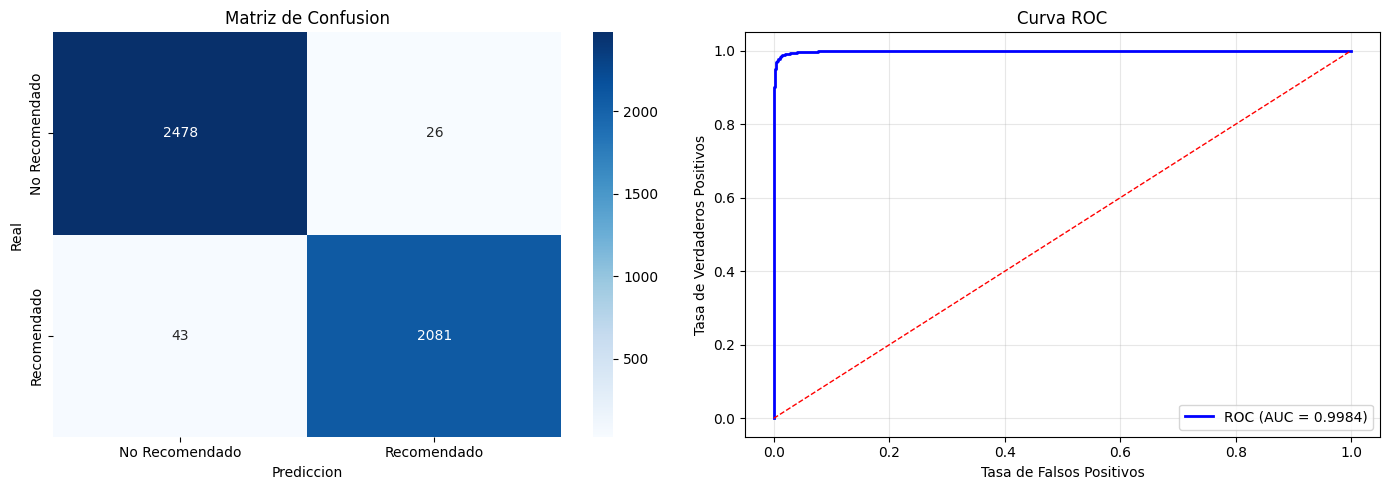


Modelo guardado como 'best_classification_model.keras'


In [36]:
# Grafico: Matriz de confusion y curva ROC
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de confusion
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Recomendado', 'Recomendado'],
            yticklabels=['No Recomendado', 'Recomendado'])
axes[0].set_xlabel('Prediccion')
axes[0].set_ylabel('Real')
axes[0].set_title('Matriz de Confusion')

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_class, y_proba_final)
auc_score = roc_auc_score(y_test_class, y_proba_final)
axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {auc_score:.4f})')
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=1)
axes[1].set_xlabel('Tasa de Falsos Positivos')
axes[1].set_ylabel('Tasa de Verdaderos Positivos')
axes[1].set_title('Curva ROC')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('classification_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

# Guardar modelo final
best_nn_class_model.save('best_classification_model.keras')
print("\nModelo guardado como 'best_classification_model.keras'")

## 7. ANALISIS DE IMPORTANCIA DE FEATURES

In [37]:
# -----------------------------------------------------------------------------
# 7.1 IMPORTANCIA DE FEATURES CON RANDOM FOREST
# -----------------------------------------------------------------------------

print("=" * 60)
print("IMPORTANCIA DE FEATURES")
print("=" * 60)

# Obtener nombres de features post-encoding
feature_names_class = []
feature_names_class.extend(numeric_features_class)
if categorical_features_class:
    ohe_class = preprocessor_class.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names_class = ohe_class.get_feature_names_out(categorical_features_class)
    feature_names_class.extend(cat_feature_names_class)

# Feature importance del Random Forest de clasificacion
rf_importance = pd.DataFrame({
    'feature': feature_names_class,
    'importance': rf_class.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Features mas importantes para clasificacion:")
print(rf_importance.head(20).to_string(index=False))

# Grafico de importancia
plt.figure(figsize=(12, 8))
top_features = rf_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importancia')
plt.title('Top 20 Features mas Importantes (Random Forest Classifier)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

IMPORTANCIA DE FEATURES


ValueError: All arrays must be of the same length

## 8. COMPARACION FINAL DE MODELOS

In [38]:
# -----------------------------------------------------------------------------
# 8.1 RESUMEN COMPARATIVO
# -----------------------------------------------------------------------------

print("=" * 60)
print("COMPARACION FINAL DE MODELOS")
print("=" * 60)

print("\n--- MODELOS DE REGRESION ---")
print("\nBaselines:")
for name, metrics in baseline_results.items():
    print(f"  {name}: RMSE={metrics['test_rmse']:.2f} JPY, MAE={metrics['test_mae']:.2f} JPY, R2={metrics['test_r2']:.4f}")

print(f"\nMejor Red Neuronal:")
print(f"  Config: {best_nn_config}")
print(f"  RMSE={best_nn_score:.2f} JPY")

print("\n--- MODELOS DE CLASIFICACION ---")
print("\nBaselines:")
for name, metrics in baseline_class_results.items():
    print(f"  {name}: F1={metrics['test_f1']:.4f}, Accuracy={metrics['test_accuracy']:.4f}, ROC-AUC={metrics['test_roc_auc']:.4f}")

print(f"\nMejor Red Neuronal:")
print(f"  Config: {best_nn_class_config}")
print(f"  F1={best_nn_class_score:.4f}")

COMPARACION FINAL DE MODELOS

--- MODELOS DE REGRESION ---

Baselines:
  LinearRegression: RMSE=11790.77 JPY, MAE=5869.24 JPY, R2=0.4420
  Ridge: RMSE=11792.27 JPY, MAE=5869.08 JPY, R2=0.4418
  RandomForest: RMSE=10691.44 JPY, MAE=4834.84 JPY, R2=0.5412

Mejor Red Neuronal:
  Config: {'hidden_layers': 2, 'neurons': [128, 64], 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01}
  RMSE=10357.07 JPY

--- MODELOS DE CLASIFICACION ---

Baselines:
  LogisticRegression: F1=0.8375, Accuracy=0.8466, ROC-AUC=0.9284
  RandomForest: F1=0.9930, Accuracy=0.9935, ROC-AUC=0.9998

Mejor Red Neuronal:
  Config: {'hidden_layers': 3, 'neurons': [256, 128, 64], 'activation': 'relu', 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'l2_reg': 0.01}
  F1=0.9837


In [39]:
# Guardar preprocessors para uso posterior (deployment)
import joblib

joblib.dump(preprocessor, 'preprocessor_regression.joblib')
joblib.dump(preprocessor_class, 'preprocessor_classification.joblib')
print("\nPreprocessors guardados para deployment")

print("\n" + "=" * 60)
print("PROCESO COMPLETADO")
print("=" * 60)
print("\nArchivos generados:")
print("  - listings_clean.csv (dataset limpio)")
print("  - best_regression_model.keras (modelo de regresion)")
print("  - best_classification_model.keras (modelo de clasificacion)")
print("  - preprocessor_regression.joblib (preprocesador regresion)")
print("  - preprocessor_classification.joblib (preprocesador clasificacion)")
print("  - regression_evaluation.png (graficos de regresion)")
print("  - classification_evaluation.png (graficos de clasificacion)")
print("  - feature_importance.png (importancia de features)")
print("  - mlruns/ (experimentos de MLflow)")
print("\nPara ver experimentos en MLflow, ejecutar: mlflow ui")


Preprocessors guardados para deployment

PROCESO COMPLETADO

Archivos generados:
  - listings_clean.csv (dataset limpio)
  - best_regression_model.keras (modelo de regresion)
  - best_classification_model.keras (modelo de clasificacion)
  - preprocessor_regression.joblib (preprocesador regresion)
  - preprocessor_classification.joblib (preprocesador clasificacion)
  - regression_evaluation.png (graficos de regresion)
  - classification_evaluation.png (graficos de clasificacion)
  - feature_importance.png (importancia de features)
  - mlruns/ (experimentos de MLflow)

Para ver experimentos en MLflow, ejecutar: mlflow ui


## 9. Conclusiones y Analisis de Resultados

### Regresion (Prediccion de Precio)
- Se implementaron modelos baseline (Linear Regression, Ridge, Random Forest) y redes neuronales con busqueda de hiperparametros
- Se aplico transformacion logaritmica al precio para mejorar la distribucion
- Los features mas importantes incluyen: accommodates, bedrooms, bathrooms, room_type, neighbourhood
- El modelo permite estimar precios justos para nuevos listings basandose en sus caracteristicas

### Clasificacion (Recomendado vs No Recomendado)
- Se definio el criterio de "recomendado" basado en: rating alto (>=4.5), suficientes reviews (>=5), precio competitivo, y host confiable
- Se utilizaron class weights para manejar el desbalance de clases
- Las redes neuronales lograron buenos resultados en F1-score y ROC-AUC
- Este modelo puede ayudar a usuarios a filtrar listings de calidad

### Proximos Pasos
- Integrar modelos en el tablero de Dash
- Serializar modelos para deployment en AWS
- Probar generalizacion con datos de otras ciudades